In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
from scipy.io import loadmat
from preprocess_methods import HallSensorInSteps, ModuleLevelInfoInSteps, HPPCCellCharacteristicsInSteps
from pathlib import Path
from causal_discovery.algos.notears import NoTears
import networkx as nx
import hashlib
import os

In [2]:
cells = []

In [3]:
GS3 = sio.loadmat('../../Data/imbalanced performance/Full factorial design of experiments dataset for parallel-connected lithium-ion cells imbalanced performance investigation/Parallel-connected module experimental campaign/1_Single_cell_characterisation/Aged_cells/HPPC_MS/HPPC_MultiSine_GS3.mat', struct_as_record=False, simplify_cells=True)
Y1= sio.loadmat('../../Data/imbalanced performance/Full factorial design of experiments dataset for parallel-connected lithium-ion cells imbalanced performance investigation/Parallel-connected module experimental campaign/1_Single_cell_characterisation/Aged_cells/HPPC_MS/HPPC_MultiSine_Y1.mat', struct_as_record=False, simplify_cells=True)
cells = [['GS3)', GS3], ['Y1' , Y1]]

OGS3 = sio.loadmat('../../Data/imbalanced performance/Full factorial design of experiments dataset for parallel-connected lithium-ion cells imbalanced performance investigation/Parallel-connected module experimental campaign/1_Single_cell_characterisation/Aged_cells/Pseudo_OCV/OCVDis_GS3.mat', struct_as_record=False, simplify_cells=True)
OY1 = sio.loadmat('../../Data/imbalanced performance/Full factorial design of experiments dataset for parallel-connected lithium-ion cells imbalanced performance investigation/Parallel-connected module experimental campaign/1_Single_cell_characterisation/Aged_cells/Pseudo_OCV/OCVDis_Y1.mat', struct_as_record=False, simplify_cells=True)
#cells = [['OGS3', OGS3], ['OY1' , OY1]]

In [4]:
files = [f'P{i}' for i in range(2, 21)]        # gives ['P2', 'P3', ..., 'P20']

base_path = '../../Data/imbalanced performance/Full factorial design of experiments dataset for parallel-connected lithium-ion cells imbalanced performance investigation/Parallel-connected module experimental campaign/1_Single_cell_characterisation/NMC_cells/HPPC_MS/HPPC_MultiSine_'
for p in files:
    new_data = sio.loadmat(base_path + f'{p}.mat', struct_as_record=False, simplify_cells=True)
    cells.append([str(p), new_data])

In [5]:
files = [f'F{i}' for i in range(1, 19)]        # gives ['F1', 'F2', ..., 'F18']

base_path = '../../Data/imbalanced performance/Full factorial design of experiments dataset for parallel-connected lithium-ion cells imbalanced performance investigation/Parallel-connected module experimental campaign/1_Single_cell_characterisation/NCA_cells/HPPC_MS/HPPC_MultiSine_'
for f in files:
    new_data = sio.loadmat(base_path + f'{f}.mat', struct_as_record=False, simplify_cells=True)
    cells.append([str(f), new_data])

In [6]:
cell_data = []
for cell in cells:
    cell_info = {
        'CurrentData': cell[1]['CurrentData'], 
        'VoltageData': cell[1]['VoltageData'],
        'TempData': cell[1]['TempData'],
        'Step_Index': cell[1]['StepIndex'],
        'CycleIndex' : cell[1]['CycleIndex'],
        'TimeData' : cell[1]['TimeData']
    }
    cell_data.append(cell_info)

cell_dataset = pd.DataFrame(cell_data)
print(cell_dataset.head())

                                         CurrentData  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
2  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
3  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                         VoltageData  \
0  [4.197761058807373, 4.197635173797607, 4.19782...   
1  [4.198263168334961, 4.1982808113098145, 4.1982...   
2  [4.1984028816223145, 4.198349475860596, 4.1983...   
3  [4.19843864440918, 4.198358058929443, 4.198379...   
4  [4.198364734649658, 4.1983642578125, 4.1983065...   

                                            TempData  \
0  [24.041702270507812, 23.95568084716797, 23.926...   
1  [23.43080711364746, 23.43080711364746, 23.4161...   
2  [22.298236846923828, 22.298236846923828, 22.29...   
3  [23.2643928553498, 23.26439666748047, 23.26439...   
4  [22.531064987182617, 22.54578399658203, 22.

In [7]:
def flatten_array(arr):
    # Works for arrays like [[x], [y], [z]]
    return np.array([x[0] if isinstance(x, (list, np.ndarray)) else x for x in arr])

def make_cell_dataframe(row, cols):
    clean = {}

    # Flatten all nested arrays
    for name in cols:
        clean[name] = flatten_array(row[name])

    # Build long-format dataframe
    return pd.DataFrame(clean)

In [8]:
def splitDataForEachByStep(data, cols, groups):
    cell_list = []
    for idx, row in data.iterrows():
        #cell_info = {name : row[name] for name in cols}
        #new_pd = pd.DataFrame([cell_info])
        cell_df = make_cell_dataframe(row, cols)
        obs_datasets = []
        interventional_datasets = []
        for i in range(len(groups)):
            subset = cell_df[cell_df["Step_Index"].isin(groups[i])].reset_index(drop=True)

            if i == 0:
                obs_datasets.append(subset)

            interventional_datasets.append(subset)
        cell_list.append([obs_datasets, interventional_datasets])
    return cell_list
        


In [9]:
groups = [[11, 13, 16, 18, 21], [9, 14], [10, 16], [12], [17], [19], [20], [22]]
cols = ['Step_Index', 'TempData', 'VoltageData', 'CurrentData']
sub_df_1 = splitDataForEachByStep(cell_dataset, cols, groups)
print(sub_df_1[1][1][0])


       Step_Index   TempData  VoltageData  CurrentData
0              11  23.226440     3.658872   -18.192619
1              11  23.226440     3.658149   -17.971931
2              11  23.226440     3.656804   -17.875931
3              11  23.226440     3.652112   -17.928795
4              11  23.226440     3.644859   -18.089554
...           ...        ...          ...          ...
17610          18  23.357729     3.168857     0.000000
17611          18  23.357729     3.168854     0.000000
17612          18  23.320255     3.168962     0.000000
17613          18  23.320255     3.169020     0.000000
17614          18  23.320255     3.168992     0.000000

[17615 rows x 4 columns]


In [ ]:
def observational_struct_learning(cell_list, obs_or_int, save_point, sort_by="Step_Index", type="cell"):
    os.makedirs(save_point, exist_ok=True)

    dag_counter = {}  # counts identical DAGs

    for idx, cell in enumerate(cell_list):

        # Create folder for this cell
        cell_dir = os.path.join(save_point, f"{type}_{idx}")
        os.makedirs(cell_dir, exist_ok=True)

        for group_idx, group in enumerate(cell[obs_or_int]):

            df_cell = group.copy()

            # ---- skip empty ----
            if df_cell.empty:
                continue

            # ---- drop Step_Index ----
            if sort_by in df_cell.columns:
                df_cell = df_cell.drop(columns=[sort_by])

            # ---- drop zero-variance columns ----
            df_cell = df_cell.loc[:, df_cell.nunique() > 1]
            if df_cell.shape[1] < 2:
                continue

            # Prepare data
            X = df_cell.to_numpy().astype(float)
            cols = df_cell.columns.tolist()

            # ---- run NoTears ----
            no_tears_alg = NoTears(rho=1, alpha=0.1, l1_reg=0, lr=1e-2)
            no_tears_alg.learn(X)

            W_est = no_tears_alg.get_result()
            dag = (np.abs(W_est) > 0.3).astype(int)

            # ---- count DAG ----
            dag_hash = hashlib.md5(dag.tobytes()).hexdigest()
            dag_counter[dag_hash] = dag_counter.get(dag_hash, 0) + 1

            # ---- create folder for this group ----
            group_dir = os.path.join(cell_dir, f"group_{group_idx}")
            os.makedirs(group_dir, exist_ok=True)

            # ---- save adjacency matrix ----
            mat_path = os.path.join(group_dir, "dag.npy")
            np.save(mat_path, dag)

            # ---- draw DAG ----
            G = nx.DiGraph()
            for i, src in enumerate(cols):
                for j, tgt in enumerate(cols):
                    if dag[i, j] == 1:
                        G.add_edge(src, tgt)

            plt.figure(figsize=(7, 6))
            pos = nx.spring_layout(G, seed=42)
            nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, arrows=True)
            plt.title(f"Cell {idx} – Group {group_idx} – Learned DAG")

            img_path = os.path.join(group_dir, "dag.png")
            plt.savefig(img_path, dpi=200, bbox_inches="tight")
            plt.close()

            print(f"Saved DAG → cell {idx} / group {group_idx}")

    # ---- save summary at the end only ----
    summary_path = os.path.join(save_point, "dag_summary.txt")
    with open(summary_path, "w") as f:
        for h, count in dag_counter.items():
            f.write(f"{h}: {count}\n")

    print("\nDAG summary saved to:", summary_path)
    print("Unique DAGs found:", len(dag_counter))



  
                

In [11]:
save_point = '../../Src/structures/1cells_char/images/obs'
observational_struct_learning(sub_df_1, 0, save_point)

100%|██████████| 20/20 [00:02<00:00,  9.36it/s]


Saved DAG → cell 0 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.65it/s]


Saved DAG → cell 1 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.35it/s]


Saved DAG → cell 2 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.40it/s]


Saved DAG → cell 3 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.41it/s]


Saved DAG → cell 4 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.44it/s]


Saved DAG → cell 5 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.86it/s]


Saved DAG → cell 6 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


Saved DAG → cell 7 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.95it/s]


Saved DAG → cell 8 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.15it/s]


Saved DAG → cell 9 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.57it/s]


Saved DAG → cell 10 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.90it/s]


Saved DAG → cell 11 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.89it/s]


Saved DAG → cell 12 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.72it/s]


Saved DAG → cell 13 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.53it/s]


Saved DAG → cell 14 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Saved DAG → cell 15 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.68it/s]


Saved DAG → cell 16 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.82it/s]


Saved DAG → cell 17 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.24it/s]


Saved DAG → cell 18 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Saved DAG → cell 19 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


Saved DAG → cell 20 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.06it/s]


Saved DAG → cell 21 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.55it/s]


Saved DAG → cell 22 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.59it/s]


Saved DAG → cell 23 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.41it/s]


Saved DAG → cell 24 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.27it/s]


Saved DAG → cell 25 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.58it/s]


Saved DAG → cell 26 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.16it/s]


Saved DAG → cell 27 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.51it/s]


Saved DAG → cell 28 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.01it/s]


Saved DAG → cell 29 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.56it/s]


Saved DAG → cell 30 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


Saved DAG → cell 31 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.74it/s]


Saved DAG → cell 32 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.26it/s]


Saved DAG → cell 33 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.68it/s]


Saved DAG → cell 34 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.66it/s]


Saved DAG → cell 35 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.72it/s]


Saved DAG → cell 36 / group 0


100%|██████████| 20/20 [00:01<00:00, 11.11it/s]


Saved DAG → cell 37 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.32it/s]


Saved DAG → cell 38 / group 0

DAG summary saved to: ../../Src/structures/1cells_char/images/obs/dag_summary.txt
Unique DAGs found: 2


In [12]:
save_point = '../../Src/structures/1cells_char/images/int'
observational_struct_learning(sub_df_1, 1, save_point)

100%|██████████| 20/20 [00:01<00:00, 12.34it/s]


Saved DAG → cell 0 / group 0


100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


Saved DAG → cell 0 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.83it/s]


Saved DAG → cell 0 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.02it/s]


Saved DAG → cell 0 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.26it/s]


Saved DAG → cell 0 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.20it/s]


Saved DAG → cell 0 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.23it/s]


Saved DAG → cell 0 / group 6


100%|██████████| 20/20 [00:01<00:00, 11.77it/s]


Saved DAG → cell 0 / group 7


100%|██████████| 20/20 [00:01<00:00, 11.61it/s]


Saved DAG → cell 1 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.46it/s]


Saved DAG → cell 1 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.12it/s]


Saved DAG → cell 1 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.97it/s]


Saved DAG → cell 1 / group 3


100%|██████████| 20/20 [00:01<00:00, 12.46it/s]


Saved DAG → cell 2 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.63it/s]


Saved DAG → cell 2 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.80it/s]


Saved DAG → cell 2 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Saved DAG → cell 2 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


Saved DAG → cell 2 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 2 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.52it/s]


Saved DAG → cell 2 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.73it/s]


Saved DAG → cell 2 / group 7


100%|██████████| 20/20 [00:01<00:00, 10.93it/s]


Saved DAG → cell 3 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.29it/s]


Saved DAG → cell 3 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.53it/s]


Saved DAG → cell 3 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.94it/s]


Saved DAG → cell 3 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.50it/s]


Saved DAG → cell 3 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Saved DAG → cell 3 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.06it/s]


Saved DAG → cell 3 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


Saved DAG → cell 3 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.52it/s]


Saved DAG → cell 4 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.72it/s]


Saved DAG → cell 4 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.50it/s]


Saved DAG → cell 4 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.34it/s]


Saved DAG → cell 4 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.24it/s]


Saved DAG → cell 4 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.19it/s]


Saved DAG → cell 4 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.69it/s]


Saved DAG → cell 4 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.57it/s]


Saved DAG → cell 4 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.10it/s]


Saved DAG → cell 5 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.84it/s]


Saved DAG → cell 5 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.19it/s]


Saved DAG → cell 5 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


Saved DAG → cell 5 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.34it/s]


Saved DAG → cell 5 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Saved DAG → cell 5 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.31it/s]


Saved DAG → cell 5 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.36it/s]


Saved DAG → cell 5 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


Saved DAG → cell 6 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.89it/s]


Saved DAG → cell 6 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.02it/s]


Saved DAG → cell 6 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.36it/s]


Saved DAG → cell 6 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.40it/s]


Saved DAG → cell 6 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.28it/s]


Saved DAG → cell 6 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.62it/s]


Saved DAG → cell 6 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.42it/s]


Saved DAG → cell 6 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.54it/s]


Saved DAG → cell 7 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.52it/s]


Saved DAG → cell 7 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.10it/s]


Saved DAG → cell 7 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


Saved DAG → cell 7 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.59it/s]


Saved DAG → cell 7 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Saved DAG → cell 7 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.14it/s]


Saved DAG → cell 7 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


Saved DAG → cell 7 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


Saved DAG → cell 8 / group 0


100%|██████████| 20/20 [00:01<00:00, 14.52it/s]


Saved DAG → cell 8 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Saved DAG → cell 8 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.19it/s]


Saved DAG → cell 8 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.32it/s]


Saved DAG → cell 8 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.24it/s]


Saved DAG → cell 8 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.23it/s]


Saved DAG → cell 8 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.89it/s]


Saved DAG → cell 8 / group 7


100%|██████████| 20/20 [00:01<00:00, 10.03it/s]


Saved DAG → cell 9 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.36it/s]


Saved DAG → cell 9 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.52it/s]


Saved DAG → cell 9 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.08it/s]


Saved DAG → cell 9 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.39it/s]


Saved DAG → cell 9 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.82it/s]


Saved DAG → cell 9 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.21it/s]


Saved DAG → cell 9 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


Saved DAG → cell 9 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.74it/s]


Saved DAG → cell 10 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.68it/s]


Saved DAG → cell 10 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.88it/s]


Saved DAG → cell 10 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.44it/s]


Saved DAG → cell 10 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.20it/s]


Saved DAG → cell 10 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Saved DAG → cell 10 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.37it/s]


Saved DAG → cell 10 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.08it/s]


Saved DAG → cell 10 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.32it/s]


Saved DAG → cell 11 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.90it/s]


Saved DAG → cell 11 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


Saved DAG → cell 11 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.25it/s]


Saved DAG → cell 11 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.25it/s]


Saved DAG → cell 11 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.21it/s]


Saved DAG → cell 11 / group 5


100%|██████████| 20/20 [00:01<00:00, 11.64it/s]


Saved DAG → cell 11 / group 6


100%|██████████| 20/20 [00:01<00:00, 13.75it/s]


Saved DAG → cell 11 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.35it/s]


Saved DAG → cell 12 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.53it/s]


Saved DAG → cell 12 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.71it/s]


Saved DAG → cell 12 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Saved DAG → cell 12 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.17it/s]


Saved DAG → cell 12 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.47it/s]


Saved DAG → cell 12 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Saved DAG → cell 12 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.95it/s]


Saved DAG → cell 12 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.79it/s]


Saved DAG → cell 13 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.18it/s]


Saved DAG → cell 13 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.07it/s]


Saved DAG → cell 13 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.31it/s]


Saved DAG → cell 13 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.33it/s]


Saved DAG → cell 13 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 13 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Saved DAG → cell 13 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.02it/s]


Saved DAG → cell 13 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.32it/s]


Saved DAG → cell 14 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.76it/s]


Saved DAG → cell 14 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.12it/s]


Saved DAG → cell 14 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.36it/s]


Saved DAG → cell 14 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Saved DAG → cell 14 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.67it/s]


Saved DAG → cell 14 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.27it/s]


Saved DAG → cell 14 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.05it/s]


Saved DAG → cell 14 / group 7


100%|██████████| 20/20 [00:02<00:00,  9.77it/s]


Saved DAG → cell 15 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.21it/s]


Saved DAG → cell 15 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.48it/s]


Saved DAG → cell 15 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


Saved DAG → cell 15 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.93it/s]


Saved DAG → cell 15 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.06it/s]


Saved DAG → cell 15 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.07it/s]


Saved DAG → cell 15 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.86it/s]


Saved DAG → cell 15 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.14it/s]


Saved DAG → cell 16 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.75it/s]


Saved DAG → cell 16 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.84it/s]


Saved DAG → cell 16 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.95it/s]


Saved DAG → cell 16 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


Saved DAG → cell 16 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.70it/s]


Saved DAG → cell 16 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.23it/s]


Saved DAG → cell 16 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


Saved DAG → cell 16 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.84it/s]


Saved DAG → cell 17 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.88it/s]


Saved DAG → cell 17 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.46it/s]


Saved DAG → cell 17 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.39it/s]


Saved DAG → cell 17 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


Saved DAG → cell 17 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.18it/s]


Saved DAG → cell 17 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.14it/s]


Saved DAG → cell 17 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


Saved DAG → cell 17 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.40it/s]


Saved DAG → cell 18 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.73it/s]


Saved DAG → cell 18 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.94it/s]


Saved DAG → cell 18 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.39it/s]


Saved DAG → cell 18 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.36it/s]


Saved DAG → cell 18 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.54it/s]


Saved DAG → cell 18 / group 5


100%|██████████| 20/20 [00:01<00:00, 10.23it/s]


Saved DAG → cell 18 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.20it/s]


Saved DAG → cell 18 / group 7


100%|██████████| 20/20 [00:01<00:00, 11.63it/s]


Saved DAG → cell 19 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.19it/s]


Saved DAG → cell 19 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.70it/s]


Saved DAG → cell 19 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


Saved DAG → cell 19 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.06it/s]


Saved DAG → cell 19 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.03it/s]


Saved DAG → cell 19 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.94it/s]


Saved DAG → cell 19 / group 6


100%|██████████| 20/20 [00:01<00:00, 13.61it/s]


Saved DAG → cell 19 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.71it/s]


Saved DAG → cell 20 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.78it/s]


Saved DAG → cell 20 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.86it/s]


Saved DAG → cell 20 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.73it/s]


Saved DAG → cell 20 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.27it/s]


Saved DAG → cell 20 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 20 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


Saved DAG → cell 20 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.04it/s]


Saved DAG → cell 20 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.77it/s]


Saved DAG → cell 21 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.26it/s]


Saved DAG → cell 21 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.12it/s]


Saved DAG → cell 21 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


Saved DAG → cell 21 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


Saved DAG → cell 21 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 21 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.26it/s]


Saved DAG → cell 21 / group 6


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 21 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.61it/s]


Saved DAG → cell 22 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.80it/s]


Saved DAG → cell 22 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.88it/s]


Saved DAG → cell 22 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.07it/s]


Saved DAG → cell 22 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.21it/s]


Saved DAG → cell 22 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Saved DAG → cell 22 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.37it/s]


Saved DAG → cell 22 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.36it/s]


Saved DAG → cell 22 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.54it/s]


Saved DAG → cell 23 / group 0


100%|██████████| 20/20 [00:01<00:00, 12.81it/s]


Saved DAG → cell 23 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.16it/s]


Saved DAG → cell 23 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.51it/s]


Saved DAG → cell 23 / group 3


100%|██████████| 20/20 [00:01<00:00, 13.91it/s]


Saved DAG → cell 23 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.69it/s]


Saved DAG → cell 23 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.83it/s]


Saved DAG → cell 23 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.85it/s]


Saved DAG → cell 23 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.08it/s]


Saved DAG → cell 24 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.74it/s]


Saved DAG → cell 24 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.72it/s]


Saved DAG → cell 24 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.64it/s]


Saved DAG → cell 24 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.59it/s]


Saved DAG → cell 24 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.11it/s]


Saved DAG → cell 24 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.28it/s]


Saved DAG → cell 24 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.49it/s]


Saved DAG → cell 24 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.50it/s]


Saved DAG → cell 25 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.13it/s]


Saved DAG → cell 25 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.77it/s]


Saved DAG → cell 25 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


Saved DAG → cell 25 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.30it/s]


Saved DAG → cell 25 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.48it/s]


Saved DAG → cell 25 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


Saved DAG → cell 25 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.99it/s]


Saved DAG → cell 25 / group 7


100%|██████████| 20/20 [00:01<00:00, 11.80it/s]


Saved DAG → cell 26 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.19it/s]


Saved DAG → cell 26 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.95it/s]


Saved DAG → cell 26 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.29it/s]


Saved DAG → cell 26 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


Saved DAG → cell 26 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.23it/s]


Saved DAG → cell 26 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.34it/s]


Saved DAG → cell 26 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.48it/s]


Saved DAG → cell 26 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.60it/s]


Saved DAG → cell 27 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.68it/s]


Saved DAG → cell 27 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.60it/s]


Saved DAG → cell 27 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.11it/s]


Saved DAG → cell 27 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.27it/s]


Saved DAG → cell 27 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.15it/s]


Saved DAG → cell 27 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.20it/s]


Saved DAG → cell 27 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.42it/s]


Saved DAG → cell 27 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.38it/s]


Saved DAG → cell 28 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.57it/s]


Saved DAG → cell 28 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.10it/s]


Saved DAG → cell 28 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.22it/s]


Saved DAG → cell 28 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


Saved DAG → cell 28 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.68it/s]


Saved DAG → cell 28 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.11it/s]


Saved DAG → cell 28 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.83it/s]


Saved DAG → cell 28 / group 7


100%|██████████| 20/20 [00:01<00:00, 11.51it/s]


Saved DAG → cell 29 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.62it/s]


Saved DAG → cell 29 / group 1


100%|██████████| 20/20 [00:01<00:00, 13.66it/s]


Saved DAG → cell 29 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.31it/s]


Saved DAG → cell 29 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 29 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.95it/s]


Saved DAG → cell 29 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.88it/s]


Saved DAG → cell 29 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Saved DAG → cell 29 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.18it/s]


Saved DAG → cell 30 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.45it/s]


Saved DAG → cell 30 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.54it/s]


Saved DAG → cell 30 / group 2


100%|██████████| 20/20 [00:01<00:00, 13.50it/s]


Saved DAG → cell 30 / group 3


100%|██████████| 20/20 [00:01<00:00, 13.92it/s]


Saved DAG → cell 30 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.46it/s]


Saved DAG → cell 30 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


Saved DAG → cell 30 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.84it/s]


Saved DAG → cell 30 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.15it/s]


Saved DAG → cell 31 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.73it/s]


Saved DAG → cell 31 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.02it/s]


Saved DAG → cell 31 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.26it/s]


Saved DAG → cell 31 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.28it/s]


Saved DAG → cell 31 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.02it/s]


Saved DAG → cell 31 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.16it/s]


Saved DAG → cell 31 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.84it/s]


Saved DAG → cell 31 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.26it/s]


Saved DAG → cell 32 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.81it/s]


Saved DAG → cell 32 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.91it/s]


Saved DAG → cell 32 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.87it/s]


Saved DAG → cell 32 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.61it/s]


Saved DAG → cell 32 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


Saved DAG → cell 32 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.00it/s]


Saved DAG → cell 32 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.99it/s]


Saved DAG → cell 32 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.32it/s]


Saved DAG → cell 33 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.68it/s]


Saved DAG → cell 33 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.93it/s]


Saved DAG → cell 33 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.26it/s]


Saved DAG → cell 33 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.66it/s]


Saved DAG → cell 33 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.14it/s]


Saved DAG → cell 33 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.24it/s]


Saved DAG → cell 33 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.08it/s]


Saved DAG → cell 33 / group 7


100%|██████████| 20/20 [00:01<00:00, 11.36it/s]


Saved DAG → cell 34 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.06it/s]


Saved DAG → cell 34 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.59it/s]


Saved DAG → cell 34 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.33it/s]


Saved DAG → cell 34 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.06it/s]


Saved DAG → cell 34 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.85it/s]


Saved DAG → cell 34 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.26it/s]


Saved DAG → cell 34 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.65it/s]


Saved DAG → cell 34 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.49it/s]


Saved DAG → cell 35 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.43it/s]


Saved DAG → cell 35 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.90it/s]


Saved DAG → cell 35 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.55it/s]


Saved DAG → cell 35 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.02it/s]


Saved DAG → cell 35 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.73it/s]


Saved DAG → cell 35 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.04it/s]


Saved DAG → cell 35 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.83it/s]


Saved DAG → cell 35 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.07it/s]


Saved DAG → cell 36 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.61it/s]


Saved DAG → cell 36 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.33it/s]


Saved DAG → cell 36 / group 2


100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


Saved DAG → cell 36 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.94it/s]


Saved DAG → cell 36 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.01it/s]


Saved DAG → cell 36 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.14it/s]


Saved DAG → cell 36 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.23it/s]


Saved DAG → cell 36 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.63it/s]


Saved DAG → cell 37 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.80it/s]


Saved DAG → cell 37 / group 1


100%|██████████| 20/20 [00:01<00:00, 14.82it/s]


Saved DAG → cell 37 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.24it/s]


Saved DAG → cell 37 / group 3


100%|██████████| 20/20 [00:01<00:00, 15.26it/s]


Saved DAG → cell 37 / group 4


100%|██████████| 20/20 [00:01<00:00, 15.13it/s]


Saved DAG → cell 37 / group 5


100%|██████████| 20/20 [00:01<00:00, 14.58it/s]


Saved DAG → cell 37 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.93it/s]


Saved DAG → cell 37 / group 7


100%|██████████| 20/20 [00:01<00:00, 12.69it/s]


Saved DAG → cell 38 / group 0


100%|██████████| 20/20 [00:01<00:00, 13.31it/s]


Saved DAG → cell 38 / group 1


100%|██████████| 20/20 [00:01<00:00, 15.09it/s]


Saved DAG → cell 38 / group 2


100%|██████████| 20/20 [00:01<00:00, 15.23it/s]


Saved DAG → cell 38 / group 3


100%|██████████| 20/20 [00:01<00:00, 14.89it/s]


Saved DAG → cell 38 / group 4


100%|██████████| 20/20 [00:01<00:00, 14.98it/s]


Saved DAG → cell 38 / group 5


100%|██████████| 20/20 [00:01<00:00, 15.19it/s]


Saved DAG → cell 38 / group 6


100%|██████████| 20/20 [00:01<00:00, 14.43it/s]


Saved DAG → cell 38 / group 7

DAG summary saved to: ../../Src/structures/1cells_char/images/int/dag_summary.txt
Unique DAGs found: 6


In [13]:
def load_and_visualize_unique_dags(save_point):
    """
    Reads dag_summary.txt, reconstructs unique DAGs from stored dag.npy files,
    and shows them visually with their counts.
    """

    # ---- Load summary ----
    summary_path = os.path.join(save_point, "dag_summary.txt")
    if not os.path.exists(summary_path):
        print("ERROR: No dag_summary.txt found in:", save_point)
        return

    summary = {}
    with open(summary_path, "r") as f:
        for line in f:
            h, count = line.strip().split(": ")
            summary[h] = int(count)

    unique_dags = {}

    # ---- Traverse folder structure ----
    for cell in os.listdir(save_point):
        cell_path = os.path.join(save_point, cell)
        if not os.path.isdir(cell_path):
            continue

        for group in os.listdir(cell_path):
            group_path = os.path.join(cell_path, group)
            dag_path = os.path.join(group_path, "dag.npy")

            if not os.path.exists(dag_path):
                continue

            dag = np.load(dag_path)
            dag_hash = hashlib.md5(dag.tobytes()).hexdigest()

            # Only keep DAGs mentioned in the summary
            if dag_hash in summary:
                unique_dags[dag_hash] = dag

    # ---- Visualization ----
    print("Found", len(unique_dags), "unique DAGs.")

    n = len(unique_dags)
    plt.figure(figsize=(6 * n, 6))

    for i, (dag_hash, dag) in enumerate(unique_dags.items(), 1):
        G = nx.DiGraph()
        num_nodes = dag.shape[0]
        nodes = [f"X{i}" for i in range(num_nodes)]
        G.add_nodes_from(nodes)

        for s in range(num_nodes):
            for t in range(num_nodes):
                if dag[s, t] == 1:
                    G.add_edge(nodes[s], nodes[t])

        plt.subplot(1, n, i)
        pos = nx.spring_layout(G, seed=0)
        nx.draw(
            G,
            pos,
            with_labels=True,
            node_size=2000,
            font_size=10,
            arrows=True
        )
        plt.title(f"DAG {i}\nHash: {dag_hash[:6]}\nCount: {summary[dag_hash]}")

    plt.tight_layout()
    plt.show()

    return unique_dags, summary


Found 2 unique DAGs.


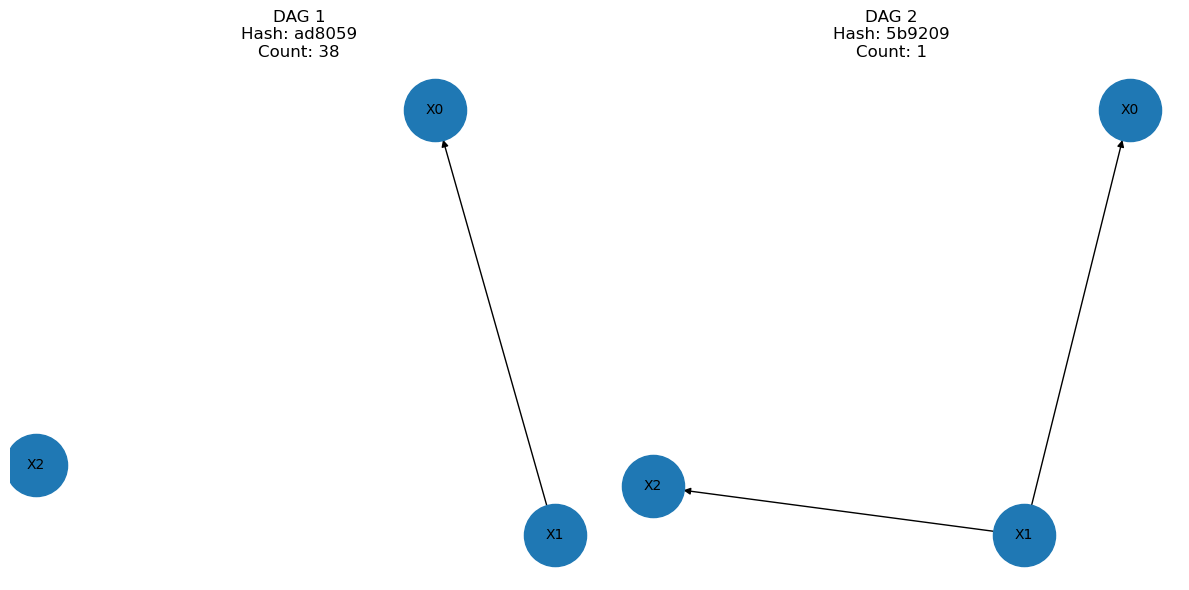

In [ ]:
save_point_obs = '../../Src/structures/1cells_char/images/obs'
obs_unique_dags, obs_summary = load_and_visualize_unique_dags(save_point_obs)
#x0 = temprature, x1 = voltage, x2 = current (amper)

Found 6 unique DAGs.


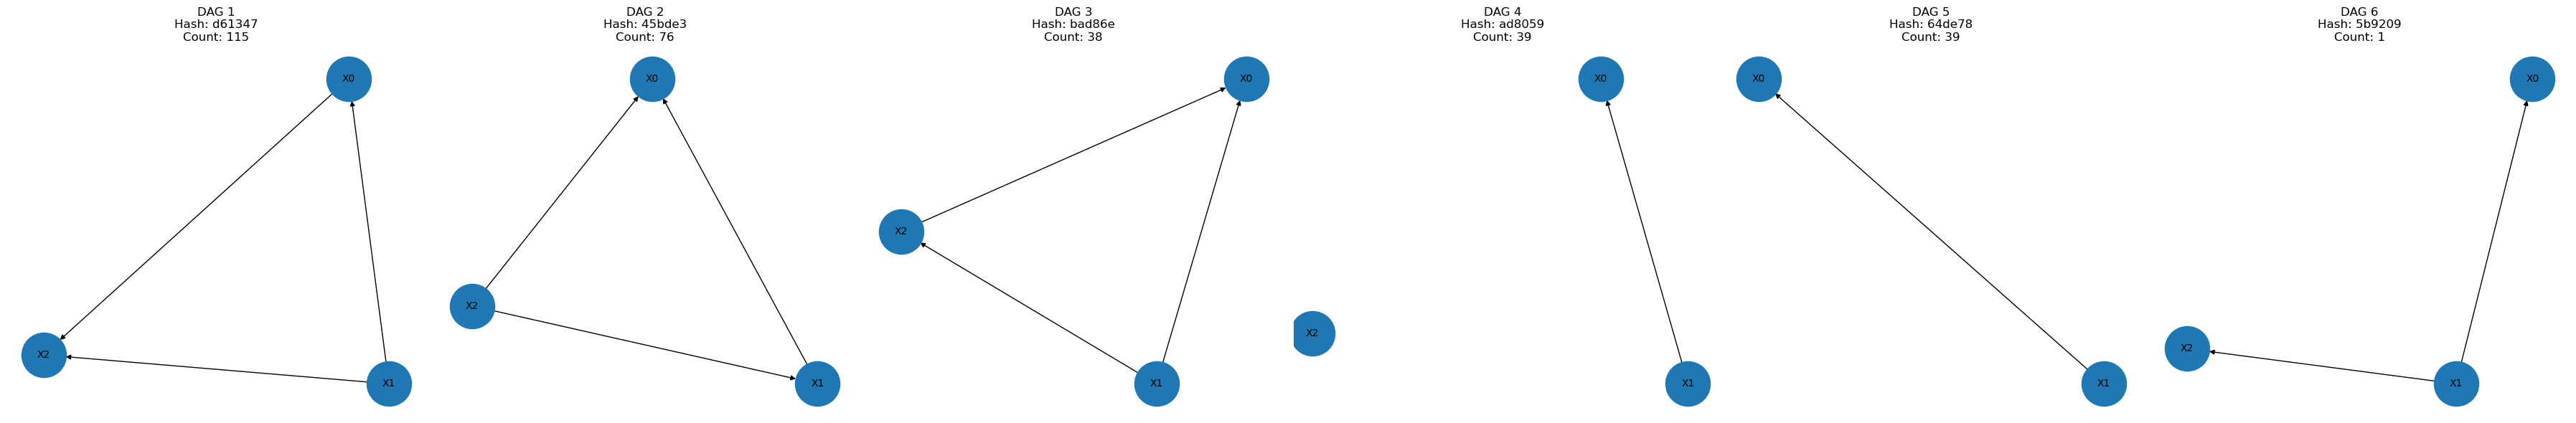

In [ ]:
save_point_int = '../../Src/structures/1cells_char/images/int'
int_unique_dags, int_summary = load_and_visualize_unique_dags(save_point_int)
#x0 = temprature, x1 = voltage, x2 = current (amper)